In [2]:
import os
import json
import numpy as np
import torch
from matplotlib import pyplot as plt
import matplotlib as mpl
from tqdm import tqdm

from models_optimized import HierarchicalPlasticRNN
from task import WhatAndWhereTask


plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams.update({'font.size': 20})
plt.rcParams['image.interpolation']='nearest'

plt.rc('axes', linewidth=1)
plt.rc('xtick.major', width=2, size=8)
plt.rc('ytick.major', width=2, size=8)
plt.rc('xtick.minor', width=1, size=4)
plt.rc('ytick.minor', width=1, size=4)
plt.rc('mathtext', default='regular')


In [3]:
exp_dir = '/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/what_where_analysis/what-where-task-analysis/rnn/exp'
model_array_dir = [f'test{i}' for i in range(1,9)] # 1e-2, 1e-6, 1e-7

f = open(os.path.join(exp_dir, model_array_dir[0], 'args.json'), 'r')
args = json.load(f)
print('loaded args')

what_where_task = WhatAndWhereTask(args['dt'], args['stim_dims'])

input_config = {
    'fixation': (1, [0]),
    'stimulus': (args['stim_dims']*2, [0]),
    'reward': (2, [0]), 
    'action': (2, [0]), 
}

output_config = {
    'action': (3, [0]), # left, right, fixation
}

total_trial_time = what_where_task.times['ITI']+\
                    what_where_task.times['fixation_time']+\
                    what_where_task.times['stim_time']+\
                    what_where_task.times['choice_reward_time']

model_specs = {'input_config': input_config, 'hidden_size': args['hidden_size'], 'output_config': output_config,
                'num_areas': args['num_areas'], 'plastic': args['plas_type']=='all', 'activation': args['activ_func'],
                'dt_x': args['dt'], 'dt_w': total_trial_time, 'tau_x': args['tau_x'], 'tau_w': args['tau_w'], 
                'e_prop': args['e_prop'], 'init_spectral': args['init_spectral'], 'balance_ei': args['balance_ei'],
                'sigma_rec': args['sigma_rec'], 'sigma_in': args['sigma_in'], 'sigma_w': args['sigma_w'], 
                'inter_regional_sparsity': (1, 1), 'inter_regional_gain': (1, 1)}

device = torch.device('cpu')

all_models = []
for model_dir in model_array_dir:
    model = HierarchicalPlasticRNN(**model_specs)
    state_dict = torch.load(os.path.join(exp_dir, model_dir, 'checkpoint.pth.tar'), 
                            map_location=torch.device('cpu'))['model_state_dict']
    print(model.load_state_dict(state_dict))
    all_models.append(model)
    print(f'model at {model_dir} loaded successfully')

loaded args


/scratch/f005d7d/ipykernel_2565134/3388126771.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(exp_dir, model_dir, 'checkpoint.pth.t

<All keys matched successfully>
model at test1 loaded successfully
<All keys matched successfully>
model at test2 loaded successfully
<All keys matched successfully>
model at test3 loaded successfully
<All keys matched successfully>
model at test4 loaded successfully
<All keys matched successfully>
model at test5 loaded successfully
<All keys matched successfully>
model at test6 loaded successfully
<All keys matched successfully>
model at test7 loaded successfully
<All keys matched successfully>
model at test8 loaded successfully


In [ ]:
def test_model(model, epoch, test_samples=10):
    model.eval()

    results_dict = {
        'block_type': [], # num_blocks
        'stimulus': [], # num_blocks X num_trials
        'inputs': [], # num_blocks X num_trials X 2*num_dims
        'img_chosen': [], # num_blocks X num_trials
        'loc_chosen': [], # num_blocks X num_trials
        'reward': [], # num_blocks X num_trials
        'reward_probs': [], # num_blocks X num_trials X 2
        'neuron_states': [], # num_blocks X num_trials X num_timesteps X num_units
        'synaptic_states': [] # num_blocks X num_trials X num_units X num_units
    }

    with torch.no_grad():
        for test_block_type in range(2):
            for batch_idx in range(test_samples):
                trial_info = what_where_task.generate_trials(
                    batch_size = args['batch_size'],
                    trials_per_block = args['trials_per_test_block'], 
                    reversal_interval = [args['trials_per_test_block']//2-args['test_reversal_interval_range']//2, 
                                        args['trials_per_test_block']//2+args['test_reversal_interval_range']//2,],
                    reward_schedule=[args['reward_probs_high'], 1-args['reward_probs_high']],
                    block_type=test_block_type,
                ) 
                stim_inputs = trial_info['stim_inputs'].to(device, dtype=torch.float)
                rewards = trial_info['rewards'].to(device)
                
                hidden = None
                w_hidden = None

                results_dict['block_type'].append(test_block_type)
                results_dict['stimulus'].append(trial_info['stim_configs'])
                results_dict['inputs'].append(trial_info['stim_inputs'])
                results_dict['reward_probs'].append(trial_info['reward_probs'])

                results_dict['img_chosen'].append([])
                results_dict['loc_chosen'].append([])
                results_dict['reward'].append([])
                
                results_dict['neuron_states'].append([])
                results_dict['synaptic_states'].append([])
                
                for i in range(len(stim_inputs)):
                    results_dict['neuron_states'][-1].append([])
                    ''' first phase, give nothing '''
                    all_x = {
                        'fixation': torch.zeros(args['batch_size'], 1, device=device),
                        'stimulus': torch.zeros_like(stim_inputs[i]),
                        'reward': torch.zeros(args['batch_size'], 2, device=device), # 2+2 for chosen and unchosen rewards
                        'action': torch.zeros(args['batch_size'], 2, device=device), # left/right
                    }

                    _, hidden, w_hidden, hs = model(all_x, steps=what_where_task.T_ITI, 
                                                    neumann_order=args['neumann_order'],
                                                    hidden=hidden, w_hidden=w_hidden, 
                                                    update_w=False, save_all_states=True)
                    results_dict['neuron_states'][-1][-1].append(hs)
                    
                    ''' second phase, give fixation '''
                    all_x = {
                        'fixation': torch.ones(args['batch_size'], 1, device=device),
                        'stimulus': torch.zeros_like(stim_inputs[i]),
                        'reward': torch.zeros(args['batch_size'], 2, device=device), # 2+2 for chosen and unchosen rewards
                        'action': torch.zeros(args['batch_size'], 2, device=device), # left/right
                    }

                    _, hidden, w_hidden, hs = model(all_x, steps=what_where_task.T_fixation, 
                                                    neumann_order=args['neumann_order'],
                                                    hidden=hidden, w_hidden=w_hidden, 
                                                    update_w=False, save_all_states=True)
                    results_dict['neuron_states'][-1][-1].append(hs)

                    ''' third phase, give stimuli and no feedback '''
                    all_x = {
                        'fixation': torch.zeros(args['batch_size'], 1, device=device),
                        'stimulus': stim_inputs[i],
                        'reward': torch.zeros(args['batch_size'], 2, device=device), # 2+2 for chosen and unchosen rewards
                        'action': torch.zeros(args['batch_size'], 2, device=device), # left/right
                    }

                    output, hidden, w_hidden, hs = model(all_x, steps=what_where_task.T_stim, 
                                                        neumann_order=args['neumann_order'],
                                                        hidden=hidden, w_hidden=w_hidden, 
                                                        update_w=False, save_all_states=True)
                    results_dict['neuron_states'][-1][-1].append(hs)

                    ''' use output to calculate action, reward, and record loss function '''
                    action = torch.multinomial(output['action'][...,:2].softmax(-1), num_samples=1).squeeze(-1) # (batch size, )
                    rwd_ch = rewards[i][range(args['batch_size']),action] # (batch size, )
                    
                    results_dict['img_chosen'][-1].append((action!=trial_info['stim_configs']).astype(int))
                    # (loc_choice, config)->img_chosen, (0,0)->0, (1,0)->1, (0,1)->1, (1,1)->0
                    results_dict['loc_chosen'][-1].append(action)
                    results_dict['reward'][-1].append(rwd_ch)

                    '''fourth phase, give stimuli and choice, and update weights'''
                    all_x = {
                        'fixation': torch.zeros(args['batch_size'], 1, device=device),
                        'stimulus': stim_inputs[i],
                        'reward': torch.eye(2, device=device)[None][range(args['batch_size']), rwd_ch], # 2+2 for chosen and unchosen rewards
                        'action': torch.eye(2, device=device)[None][range(args['batch_size']), action], # left/right
                    }

                    output, hidden, w_hidden, hs = model(all_x, steps=what_where_task.T_choice, 
                                                    neumann_order=args['neumann_order'],
                                                    hidden=hidden, w_hidden=w_hidden, 
                                                    update_w=True, save_all_states=True)
                    results_dict['neuron_states'][-1][-1].append(hs)
                    results_dict['synaptic_states'][-1].append(w_hidden)

                    results_dict['neuron_states'][-1][-1] = np.concatenate(results_dict['neuron_states'][-1][-1], axis=0) # num_timesteps, batch_size, num_dims

                # collect results in 
                results_dict['img_chosen'][-1] = np.array(results_dict['img_chosen'][-1]) # num_trials X batch_size
                results_dict['loc_chosen'][-1] = np.array(results_dict['loc_chosen'][-1]) # num_trials X batch_size 
                results_dict['reward'][-1] = np.array(results_dict['reward'][-1]) # num_trials X batch_size

                results_dict['neuron_states'][-1] = np.stack(results_dict['neuron_states'][-1]) # num_trials, num_timesteps, batch_size, num_dims
                results_dict['synaptic_states'][-1] = np.stack(results_dict['synaptic_states'][-1]) # num_trials X batch_size X num_dims X num_dims
        
            results_dict

        return results_dict

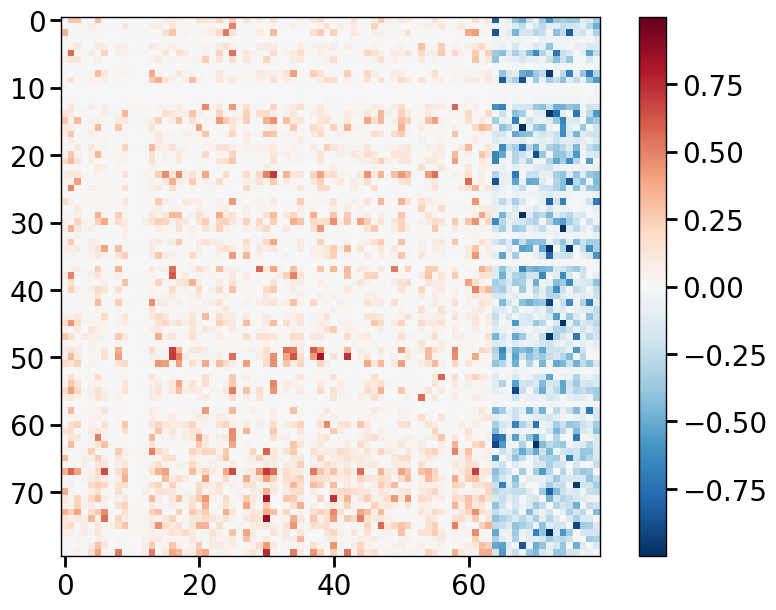

In [221]:
plt.imshow(all_models[np.random.randint(0, len(all_models))].rnn.h2h.effective_weight().detach(), cmap='RdBu_r', norm=mpl.colors.CenteredNorm(vcenter=0))
plt.colorbar()


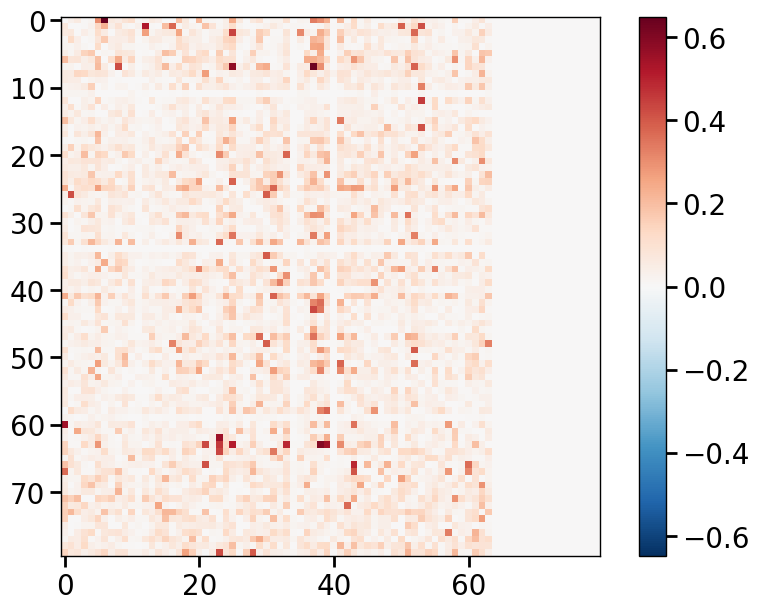

In [222]:
plt.imshow(all_models[np.random.randint(0, len(all_models))].plasticity.effective_lr().detach(),  cmap='RdBu_r', norm=mpl.colors.CenteredNorm(vcenter=0))
plt.colorbar()

# Decomposition of input and output weights

The input weight is equal to $[I_{left, dim1}\ \ I_{left, dim2}\ \ I_{right, dim}\ \ I_{right, dim2}]$. We want to get $\bar{I}_{left}$, $\bar{I}_{right}$, $\bar{I}_{dim1}$, $\bar{I}_{dim2}$, as well as the residuals.

In [4]:
'''decompose the input weights'''

all_model_input_weights_raw = []

for mdl in all_models:
    all_model_input_weights_raw.append(mdl.rnn.x2h['stimulus'].effective_weight().detach())
    
all_model_input_weights_raw = torch.stack(all_model_input_weights_raw, dim=0).reshape(-1, args['hidden_size'], 4) # (num_models, hidden_size, 4)

all_model_inputs_effective = all_model_input_weights_raw @ np.array([[1,-1,1,-1],[1,0,-1,0], [0,1,0,-1]]).T[None] # there's only 2 dimensions for stimulus input



In [5]:
'''decompose the output weights'''

all_model_output_weights_raw = []

for mdl in all_models:
    all_model_output_weights_raw.append(mdl.h2o['action'].effective_weight().detach())
    
all_model_output_weights_raw = torch.stack(all_model_output_weights_raw, dim=0).reshape(-1, 3, args['hidden_size']).permute(0,2,1) # (num_models, hidden_size, 4)

all_model_outputs_effective = np.stack([
    (all_model_output_weights_raw[:,:,1]-all_model_output_weights_raw[:,:,0]),
    (all_model_output_weights_raw[:,:,2])], axis=-1)

In [6]:
'''decompose the action feedback weights'''

all_model_action_feedback_weights = []

for mdl in all_models:
    all_model_action_feedback_weights.append(mdl.rnn.x2h['action'].effective_weight().detach())
    
all_model_action_feedback_weights = torch.stack(all_model_action_feedback_weights, dim=0) # (num_models, hidden_size, 2)

all_model_action_feedback_weights_effective = (all_model_action_feedback_weights[:,:,1]-all_model_action_feedback_weights[:,:,0])[...,None]

'''decompose the reward weights'''
all_model_reward_weights = []
for mdl in all_models:
    all_model_reward_weights.append(mdl.rnn.x2h['reward'].effective_weight().detach())
all_model_reward_weights = torch.stack(all_model_reward_weights, dim=0) # (num_models, hidden_size, 2)
all_model_reward_weights_effective = (all_model_reward_weights[:,:,1]-all_model_reward_weights[:,:,0])[...,None]

'''decompose the fixation weights'''
all_model_fixation_weights = []
for mdl in all_models:
    all_model_fixation_weights.append(mdl.rnn.x2h['fixation'].effective_weight().detach())
all_model_fixation_weights = torch.stack(all_model_fixation_weights, dim=0) # (num_models, hidden_size, 1)




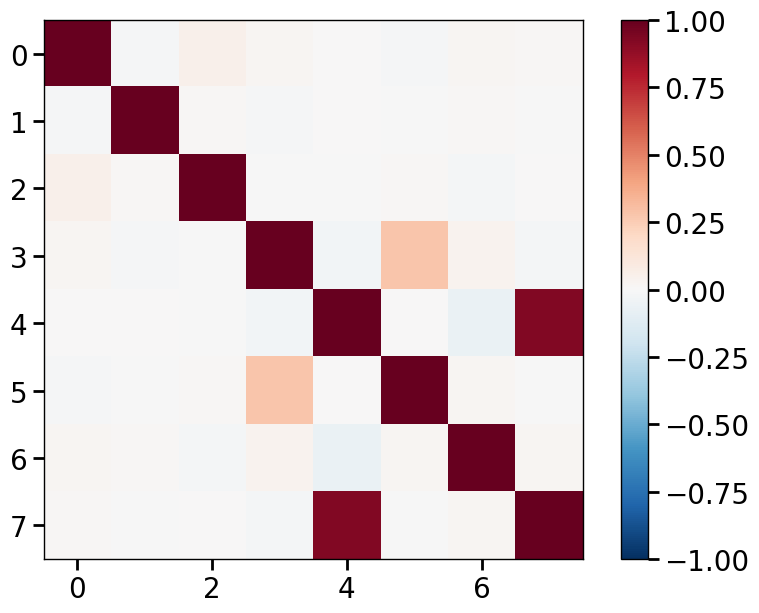

In [7]:
plt.imshow(
    np.mean([np.corrcoef(np.concatenate([all_model_inputs_effective, 
                                         all_model_outputs_effective, 
                                         all_model_action_feedback_weights_effective,
                                         all_model_reward_weights_effective,
                                         all_model_fixation_weights], axis=-1)[i].T) for i in range(8)], 0),
     cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()

- We should have for input weights (2 dim for stimulus, 1 dim for action feedback, 1 dim for reward, 1 dim for fixation, 1 dim for action output)

In [8]:
'''get all model's recurrent weights'''

all_model_recurrent_weights = []
for mdl in all_models:
    all_model_recurrent_weights.append(mdl.rnn.h2h.effective_weight().detach())
all_model_recurrent_weights = torch.stack(all_model_recurrent_weights, dim=0)  # (num_models, hidden_size, hidden_size)


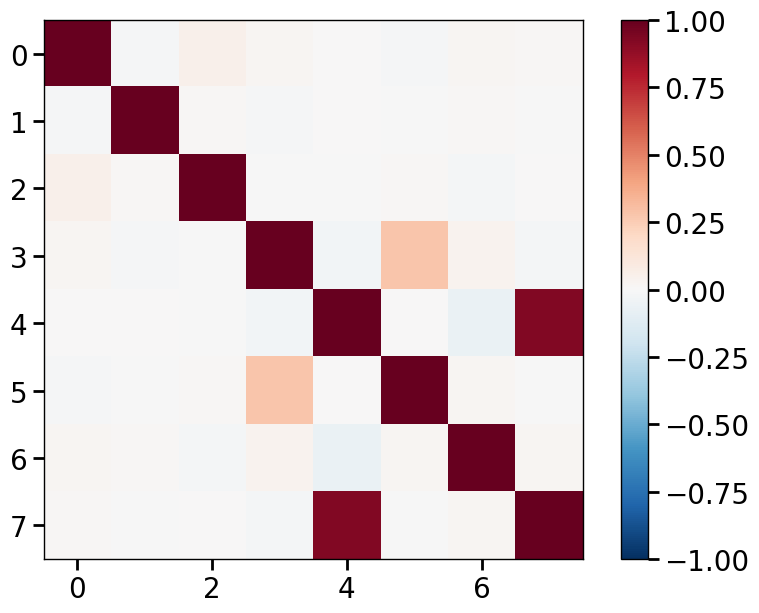

In [9]:
all_model_bases =np.concatenate([all_model_inputs_effective, 
                                         all_model_outputs_effective, 
                                         all_model_action_feedback_weights_effective,
                                         all_model_reward_weights_effective,
                                         all_model_fixation_weights], axis=-1)

all_model_bases = all_model_bases / (np.linalg.norm(all_model_bases, axis=1, keepdims=True)+1e-10)

plt.imshow(np.mean([np.corrcoef(all_model_bases[i].T) for i in range(8)], 0), cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()

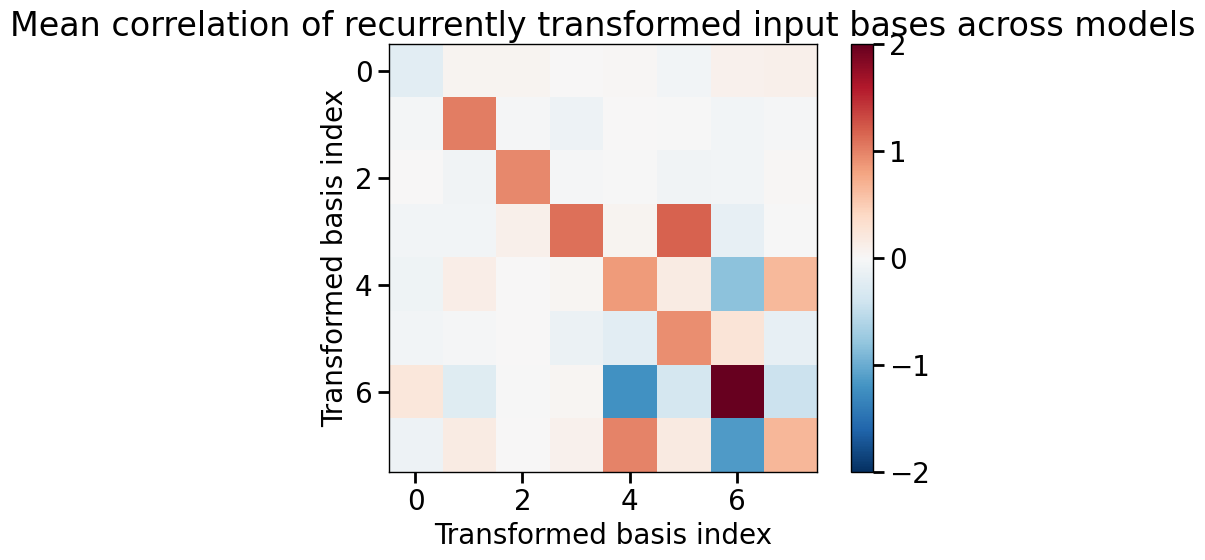

In [10]:
# Visualize how the recurrent weight transforms the input bases by performing a matrix change of variable
# For each model, transform the input bases by its recurrent weight, then average the resulting correlation matrices

num_models = all_model_recurrent_weights.shape[0]
num_bases = all_model_bases.shape[-1]

corrs = []
for i in range(num_models):
    W_rec = all_model_recurrent_weights[i].numpy()  # (hidden_size, hidden_size)
    input_bases = all_model_bases[i]  # (hidden_size, num_bases)
    transformed_bases = W_rec @ input_bases  # (hidden_size, num_bases)
    # transformed_bases = transformed_bases / np.linalg.norm(transformed_bases, axis=0, keepdims=True)
    corr = input_bases.T @ transformed_bases # (num_bases, num_bases)
    corrs.append(corr)

mean_corr = np.mean(corrs, axis=0)
plt.figure(figsize=(8,6))
plt.imshow(mean_corr, cmap='RdBu_r', norm=mpl.colors.CenteredNorm(vcenter=0, halfrange=2))
plt.colorbar()
plt.title("Mean correlation of recurrently transformed input bases across models")
plt.xlabel("Transformed basis index")
plt.ylabel("Transformed basis index")

plt.tight_layout()

plt.show()



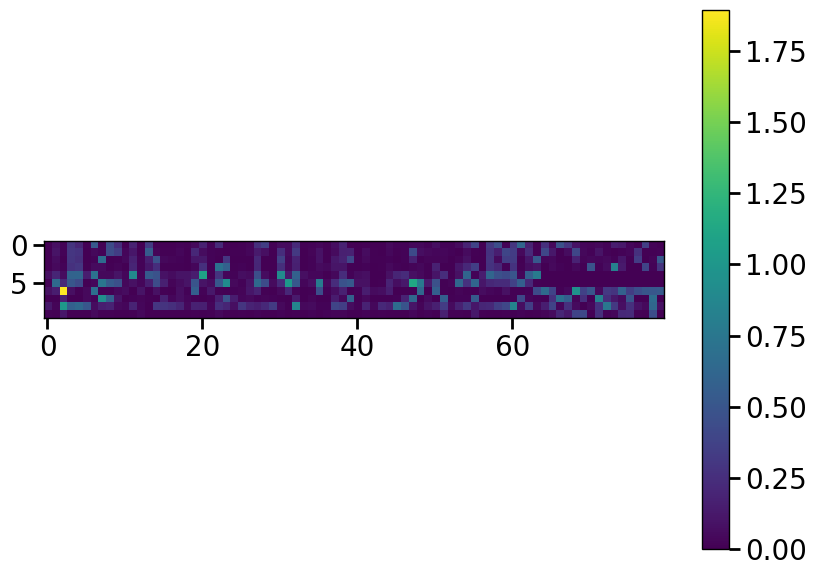

In [246]:
all_model_weights = np.concatenate([all_model_input_weights_raw, 
                                    all_model_output_weights_raw[...,:2], 
                                    all_model_action_feedback_weights,
                                    all_model_reward_weights], axis=-1)

plt.imshow(all_model_weights[0].T)
plt.colorbar()

In [249]:
all_model_weights.shape

(8, 80, 10)

n_clusters=2, silhouette_score=0.244
n_clusters=3, silhouette_score=0.308
n_clusters=4, silhouette_score=0.157
n_clusters=5, silhouette_score=0.156
n_clusters=6, silhouette_score=0.126
n_clusters=7, silhouette_score=0.108
n_clusters=8, silhouette_score=0.119
n_clusters=9, silhouette_score=0.118
n_clusters=10, silhouette_score=0.101


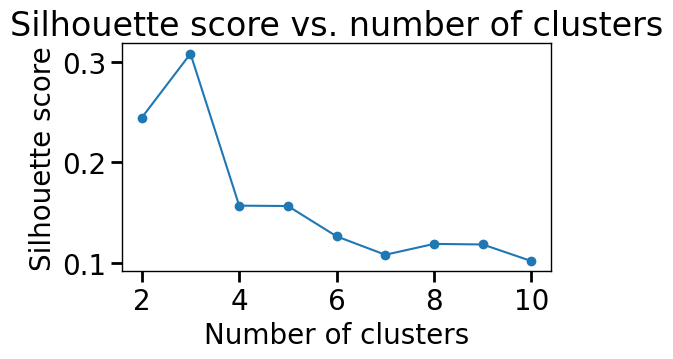

In [275]:
from sklearn.cluster import SpectralClustering

from sklearn.metrics import silhouette_score

# all_model_weights: shape (num_models, hidden_size, num_features)
# Concatenate all hidden units from all models: (num_models * hidden_size, num_features)
all_units = all_model_weights[:,:64].reshape(-1, all_model_weights.shape[-1])

silhouette_scores = []
cluster_range = range(2, 11)  # Try 2 to 10 clusters

for n_clusters in cluster_range:
    clustering = SpectralClustering(n_clusters=n_clusters, affinity='rbf', assign_labels='kmeans', gamma=1/all_units.shape[-1], n_init=20)
    labels = clustering.fit_predict(all_units)
    score = silhouette_score(all_units, labels, metric='cosine')
    silhouette_scores.append(score)
    print(f"n_clusters={n_clusters}, silhouette_score={score:.3f}")

plt.figure(figsize=(6,4))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.title("Silhouette score vs. number of clusters")
plt.tight_layout()
plt.show()



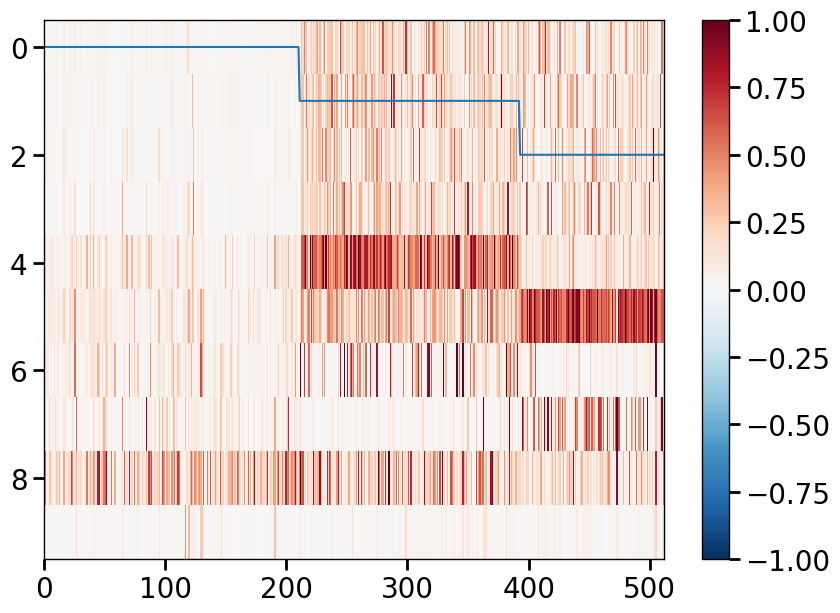

In [276]:
# Let's use the best number of clusters (highest silhouette score)
best_n_clusters = 3
clustering = SpectralClustering(n_clusters=best_n_clusters, affinity='rbf', assign_labels='kmeans', gamma=1/all_units.shape[-1], n_init=20)
labels = clustering.fit_predict(all_units)

# Calculate centroids
centroids = np.concatenate([all_units[labels == k] for k in range(best_n_clusters)], axis=0)


plt.imshow(centroids.T, aspect='auto', cmap='RdBu_r', norm=mpl.colors.CenteredNorm(vcenter=0, halfrange=1))
plt.plot(np.sort(labels))
plt.colorbar()
plt.show()
